In [1]:
print("Hello World")

Hello World


Running with minimal dimensions, on this slightly artifical subset produced good results, I want to test if we get better results using more dimensions, so to see if the extra processing time leads to better results. The minimal dimension workbook used 9 dimensions. For this I will use 20. I will choose 9 that rated highly on my grid search of the whole dataset randomly sampled. These are:

Cat

http_host
http_request_line
http_request_method
http_request_version
ssdp
http_request_full_uri




Numerical
ip_ttl
udp_dstport
udp_time_delta


In [2]:
readFile="Data/parquet/subSampleWholeDataSet"

In [3]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt 
from pyspark.sql.functions import col

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("WiFi") \
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

In [5]:
df=spark.read.parquet(readFile)

In [6]:
df.groupBy('StringLabel').count().show()
df.count()

+----------------+------+
|     StringLabel| count|
+----------------+------+
|           Krack|  2500|
|             SSH|  3541|
|          Botnet|  2725|
|            SSDP|  2622|
|   SQL_Injection|  2629|
|         RogueAP|  1310|
|       Evil_Twin|  3088|
|Website_spoofing|  2397|
|       (Re)Assoc|  3331|
|           Disas|  2957|
|          Normal|596802|
|          Deauth|  2249|
|           Kr00k|  3758|
|         Malware|  2498|
+----------------+------+



632407

https://docs.microsoft.com/en-us/azure/databricks/_static/notebooks/getting-started/get-started-with-mllib-dbr7.html as a guide

In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [8]:
categoricalCols = [
    "wlan_tag_length",
    "wlan_country_info_fnm",
    "wlan_da",
    "wlan_sa",
    "wlan_bssid",
    "ip_src",
    "ip_dst",
    "http_host",
    "http_request_line",
    "http_request_method",
    "http_request_version",
    "ssdp",
    "http_request_full_uri"
]
   

In [9]:
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "index" for x in categoricalCols]).setHandleInvalid("keep") 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 

In [10]:
numericCols=[
    "wlan_fixed_reason_code",
    "radiotap_channel_freq",
    "udp_length",
    "ip_ttl",
    "udp_dstport",
    "udp_time_delta"
]

In [11]:
from pyspark.ml.feature import VectorAssembler
 
# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [12]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

we want to do a test train split on our subsample

In [13]:
train, test = df.randomSplit([0.8,0.2])


In [14]:
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

Events for the training 506155
Events for the validation 126252


we take a subsample and cache it for the grid search

In [15]:
gridSample = train.sample(fraction=1.0/25, withReplacement=False).cache()
print('We will use',gridSample.count(),' events for the grid search.')
gridSample.groupBy('label').count().show()
gridSample.groupBy('StringLabel').count().show()

We will use 19852  events for the grid search.
+-----+-----+
|label|count|
+-----+-----+
|    1| 1091|
|    0|18761|
+-----+-----+

+----------------+-----+
|     StringLabel|count|
+----------------+-----+
|           Krack|   64|
|             SSH|  107|
|          Botnet|   81|
|            SSDP|  100|
|   SQL_Injection|   85|
|         RogueAP|   41|
|       Evil_Twin|   85|
|Website_spoofing|   63|
|       (Re)Assoc|  114|
|           Disas|   85|
|          Normal|18761|
|          Deauth|   80|
|           Kr00k|  120|
|         Malware|   66|
+----------------+-----+



In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features', 
                            maxBins=20, subsamplingRate=0.7,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                            minInstancesPerNode=2)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_pipe = Pipeline(stages=[stringIndexer, encoder, vecAssembler,rf])





paramGrid = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [10,20])\
  .addGrid(rf.numTrees, [50])\
  .build()

cv = CrossValidator(estimator=rf_pipe, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=2, parallelism=4)

In [17]:
%%time
bestModel = cv.fit(gridSample)
 

CPU times: user 496 ms, sys: 194 ms, total: 689 ms
Wall time: 3min 24s


In [18]:
print('BestModel:\n\t-maxDepth =',bestModel.bestModel.stages[-1]._java_obj.getMaxDepth())
print('\t-Feature Importance =',bestModel.bestModel.stages[-1]._java_obj.featureImportances())
print('BestModel:\n\t-maxDepth =',bestModel.bestModel.stages[-1]._java_obj.getNumTrees())

BestModel:
	-maxDepth = 10
	-Feature Importance = (1314,[0,1,2,3,4,6,7,8,9,10,11,12,18,20,22,23,25,26,27,28,29,30,31,33,34,35,36,39,45,57,62,66,81,82,83,85,86,88,89,95,129,130,131,132,145,149,151,159,160,239,327,328,401,575,589,631,698,1308,1309,1310,1311],[0.10438350581730019,0.015623001928454987,0.00400921078705673,4.7271606488639186E-4,0.0010190714504807103,0.0036771644016795496,3.262720110544783E-5,0.0015522346549495273,1.357946062153346E-4,5.393990751525057E-5,8.318093261496383E-5,1.3890414818097647E-4,4.132172154270418E-4,0.02574524890449987,4.3871420578146477E-4,0.011515759695534608,0.03422168536913775,1.0714771041643657E-4,8.637598880323078E-4,1.4703258899330461E-5,0.0011893815125085898,1.80360125771345E-4,1.307662417530646E-4,0.15910004386994578,7.190746809175481E-4,6.109370150350306E-4,8.70704983075547E-5,8.628446505700389E-4,3.0036367659721553E-4,5.358732052126202E-4,3.4647588839700934E-4,3.641190188790085E-4,1.4386653795669624E-5,0.002459625279301684,2.7382478013129455E-5,8

In [19]:
transformedBestModel=bestModel.transform(gridSample)

In [20]:
import pandas as pd

p = pd.DataFrame(transformedBestModel.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+transformedBestModel.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

In [21]:
p.name

0                                   wlan_tag_lengthOHE_NA
1                                    wlan_tag_lengthOHE_4
2       wlan_tag_lengthOHE_7-8-1-4-6-20-26-22-4-12-5-2-24
3       wlan_tag_lengthOHE_7-8-4-52-1-2-20-5-26-22-8-1...
4                               wlan_tag_lengthOHE_177-24
                              ...                        
1309                                radiotap_channel_freq
1310                                           udp_length
1311                                               ip_ttl
1312                                          udp_dstport
1313                                       udp_time_delta
Name: name, Length: 1314, dtype: object

In [22]:

from itertools import chain
attrs = sorted(
    (attr["idx"], attr["name"])
    for attr in (
        chain(*transformedBestModel.schema["features"].metadata["ml_attr"]["attrs"].values())
    )
) 

In [23]:
ImportanceArray=[
    (name,  bestModel.bestModel.stages[-1].featureImportances[idx])
    for idx, name in attrs
    if bestModel.bestModel.stages[-1].featureImportances[idx]
]

In [24]:
ImportanceArray.sort(key=lambda row: (row[1]), reverse=True)

In [25]:
ImportanceArray

[('wlan_saOHE_04:ed:33:e0:24:82', 0.2329099500465294),
 ('wlan_fixed_reason_code', 0.22745103151179497),
 ('wlan_daOHE_04:ed:33:e0:24:82', 0.15910004386994578),
 ('wlan_tag_lengthOHE_NA', 0.10438350581730019),
 ('wlan_bssidOHE_0c:9d:92:54:fe:35', 0.08272827161267624),
 ('radiotap_channel_freq', 0.05894093178839726),
 ('wlan_daOHE_a4:b1:c1:91:4c:72', 0.03422168536913775),
 ('wlan_country_info_fnmOHE_1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1',
  0.02574524890449987),
 ('wlan_tag_lengthOHE_4', 0.015623001928454987),
 ('wlan_daOHE_0c:9d:92:54:fe:30', 0.011515759695534608),
 ('udp_length', 0.006371144619634335),
 ('wlan_tag_lengthOHE_7-8-1-4-6-20-26-22-4-12-5-2-24', 0.00400921078705673),
 ('wlan_bssidOHE_ff:ff:ff:ff:ff:ff', 0.003975823599839866),
 ('ip_srcOHE_192.168.2.130', 0.003970056777685278),
 ('wlan_tag_lengthOHE_8-1-1-5-26-22-8-5-12-5-9-24', 0.0036771644016795496),
 ('ip_srcOHE_20.50.64.3', 0.0027322929711481106),
 ('wlan_saOHE_a4:b1:c1:91:4c:72', 0.002459625279301684),
 ('ip_srcOHE_192.168.2.

In [26]:
len(bestModel.bestModel.stages[-1].featureImportances)

1314

In [27]:
gridSample.unpersist()

DataFrame[frame_encap_type: int, frame_len: int, frame_number: int, frame_time: string, frame_time_delta: double, frame_time_delta_displayed: double, frame_time_epoch: double, frame_time_relative: double, radiotap_channel_flags_cck: int, radiotap_channel_flags_ofdm: int, radiotap_channel_freq: int, radiotap_datarate: double, radiotap_dbm_antsignal: int, radiotap_length: int, radiotap_mactime: double, radiotap_present_tsft: string, radiotap_rxflags: string, radiotap_timestamp_ts: bigint, radiotap_vendor_oui: int, wlan_duration: int, wlan_analysis_kck: string, wlan_analysis_kek: string, wlan_bssid: string, wlan_country_info_fnm: string, wlan_country_info_code: string, wlan_da: string, wlan_fc_ds: string, wlan_fc_frag: int, wlan_fc_order: int, wlan_fc_moredata: int, wlan_fc_protected: int, wlan_fc_pwrmgt: int, wlan_fc_type: int, wlan_fc_retry: int, wlan_fc_subtype: int, wlan_fcs_bad_checksum: int, wlan_fixed_beacon: int, wlan_fixed_capabilities_ess: int, wlan_fixed_capabilities_ibss: int,

In [28]:
rf2 = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=50, maxDepth=20)
pipeline2 = Pipeline(stages=[stringIndexer, encoder, vecAssembler,rf2])

In [29]:
%%time
train.cache()
pipelineModel = pipeline2.fit(train)
train.unpersist()

CPU times: user 199 ms, sys: 90.9 ms, total: 290 ms
Wall time: 16min 6s


DataFrame[frame_encap_type: int, frame_len: int, frame_number: int, frame_time: string, frame_time_delta: double, frame_time_delta_displayed: double, frame_time_epoch: double, frame_time_relative: double, radiotap_channel_flags_cck: int, radiotap_channel_flags_ofdm: int, radiotap_channel_freq: int, radiotap_datarate: double, radiotap_dbm_antsignal: int, radiotap_length: int, radiotap_mactime: double, radiotap_present_tsft: string, radiotap_rxflags: string, radiotap_timestamp_ts: bigint, radiotap_vendor_oui: int, wlan_duration: int, wlan_analysis_kck: string, wlan_analysis_kek: string, wlan_bssid: string, wlan_country_info_fnm: string, wlan_country_info_code: string, wlan_da: string, wlan_fc_ds: string, wlan_fc_frag: int, wlan_fc_order: int, wlan_fc_moredata: int, wlan_fc_protected: int, wlan_fc_pwrmgt: int, wlan_fc_type: int, wlan_fc_retry: int, wlan_fc_subtype: int, wlan_fcs_bad_checksum: int, wlan_fixed_beacon: int, wlan_fixed_capabilities_ess: int, wlan_fixed_capabilities_ibss: int,

In [30]:
%%time
test.cache()
pred = pipelineModel.transform(test)
test.unpersist()

CPU times: user 14.8 ms, sys: 7 ms, total: 21.8 ms
Wall time: 247 ms


DataFrame[frame_encap_type: int, frame_len: int, frame_number: int, frame_time: string, frame_time_delta: double, frame_time_delta_displayed: double, frame_time_epoch: double, frame_time_relative: double, radiotap_channel_flags_cck: int, radiotap_channel_flags_ofdm: int, radiotap_channel_freq: int, radiotap_datarate: double, radiotap_dbm_antsignal: int, radiotap_length: int, radiotap_mactime: double, radiotap_present_tsft: string, radiotap_rxflags: string, radiotap_timestamp_ts: bigint, radiotap_vendor_oui: int, wlan_duration: int, wlan_analysis_kck: string, wlan_analysis_kek: string, wlan_bssid: string, wlan_country_info_fnm: string, wlan_country_info_code: string, wlan_da: string, wlan_fc_ds: string, wlan_fc_frag: int, wlan_fc_order: int, wlan_fc_moredata: int, wlan_fc_protected: int, wlan_fc_pwrmgt: int, wlan_fc_type: int, wlan_fc_retry: int, wlan_fc_subtype: int, wlan_fcs_bad_checksum: int, wlan_fixed_beacon: int, wlan_fixed_capabilities_ess: int, wlan_fixed_capabilities_ibss: int,

In [31]:
pred_pd = pred.select(['label', 'prediction', 'probability']).toPandas()
pred_pd.head()

,label,prediction,probability
0,0,0.0,"[0.9899124110120341, 0.010087588987965837]"
1,0,0.0,"[0.9899124110120341, 0.010087588987965837]"
2,0,0.0,"[0.9899124110120341, 0.010087588987965837]"
3,0,0.0,"[0.9899124110120341, 0.010087588987965837]"
4,0,0.0,"[0.9899124110120341, 0.010087588987965837]"


In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(pred_pd['label'], pred_pd['prediction'])
tn, fp, fn, tp = confusion_matrix(pred_pd['label'], pred_pd['prediction']).ravel()

In [33]:
print("There are "+str(tn)+ " true negatives")
print("There are "+str(tp)+ " true positives")
print("There are "+str(fn)+ " false negatives")
print("There are "+str(fp)+ " false positives")

There are 118945 true negatives
There are 2370 true positives
There are 4787 false negatives
There are 150 false positives


In [34]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef

precision,recall,fscore,support = precision_recall_fscore_support(pred_pd['label'], pred_pd['prediction'], average='binary')
MCC = matthews_corrcoef(pred_pd['label'], pred_pd['prediction'])
print("The precision is "+str(precision))
print("The recall is "+str(recall))
print("The fscore is "+str(fscore))
print("The Matthews correlation coefficient is "+str(MCC))

The precision is 0.9404761904761905
The recall is 0.33114433421824785
The fscore is 0.48982122558644203
The Matthews correlation coefficient is 0.5454228621383743


Using more dimensions slightly reduces the number of false negatives but with more false positives. We will work on the smaller dimension set for tuning as the results are pretty similar and we can process the data more quickly. Then look at bringing in more later to see if it helps with performance. We will look at adjusting the threshold as we did on the minimal dimensions workbook

In [35]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_label'] = pred_pd['label'].map(lambda x: np.eye(2)[int(x)])

In [36]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_label'].tolist())

In [37]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve( y_true[:,0], y_pred[:,0])


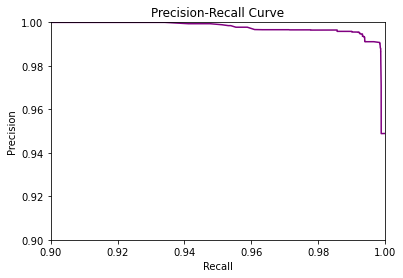

In [38]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
plt.xlim([0.90, 1])
plt.ylim([0.90, 1])

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [39]:
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/ suggestion on setting thresholds
from numpy import argmax
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (threshold[ix], fscore[ix]))


Best Threshold=0.662450, F-Score=0.995


In [46]:
#taking 1-best threshold
threshold = 0.34
y_pred2 = (y_pred[:, 1] > threshold).astype('float')

tn, fp, fn, tp = confusion_matrix(pred_pd['label'], y_pred2).ravel()

In [47]:
print("There are "+str(tn)+ " true negatives")
print("There are "+str(tp)+ " true positives")
print("There are "+str(fn)+ " false negatives")
print("There are "+str(fp)+ " false positives")

There are 118895 true negatives
There are 6042 true positives
There are 1115 false negatives
There are 200 false positives


In [48]:
precision,recall,fscore,support = precision_recall_fscore_support(pred_pd['label'], y_pred2, average='binary')
MCC2 = matthews_corrcoef(pred_pd['label'], y_pred2)
print("The precision is "+str(precision))
print("The recall is "+str(recall))
print("The fscore is "+str(fscore))
print("The Matthews correlation coefficient is "+str(MCC2))

The precision is 0.9679589875040051
The recall is 0.844208467234875
The fscore is 0.9018583476378834
The Matthews correlation coefficient is 0.8987245414932079


So compared to the minimal dimensions adjustments we have fewer false posatives by are actually missing more attacks. so we have have a higher presicion but a lower recall and MCC, and these two metrics are more relavant for intrustion detection. 